In [6]:
import os
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import time
from datetime import timedelta
from scipy import linalg
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
%cd ..
from graphs import (perform_profit_factor_permutation_test, plot_drawdown,
                    plot_cumulative_returns, plot_return_distribution,
                    plot_returns_by_hour, plot_trade_direction_and_exit_analysis,
                    plot_rolling_sharpe_ratio, plot_kelly_criterion_analysis)
from utils import MARKET_TZ, get_next_trading_day, is_market_open, calculate_profit_factor
%cd linear_algebra

f:\Coding\Trading
f:\Coding\Trading\linear_algebra


In [7]:
def get_historical_data(ticker, start_date, end_date, interval, max_retries=3, backoff_factor=2):
    """
    Retrieve historical data with retry logic for rate limits.
    Returns timezone-aware DataFrame in MARKET_TZ.
    """
    os.makedirs('historical_data', exist_ok=True)
    file_path = f'historical_data/{ticker}.csv'
    
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    for attempt in range(max_retries + 1):
        try:
            new_data = yf.download(ticker, 
                                 start=start_date,
                                 end=end_date,
                                 interval=interval,
                                 progress=False)
            
            if not new_data.empty:
                # Process columns and timezone
                if isinstance(new_data.columns, pd.MultiIndex):
                    new_data.columns = new_data.columns.get_level_values(0)
                    
                if new_data.index.tzinfo is None:
                    new_data.index = new_data.index.tz_localize(MARKET_TZ)
                else:
                    new_data.index = new_data.index.tz_convert(MARKET_TZ)
                
                return new_data
            
            print(f"Fetched data for {ticker} from {start_date} to {end_date}: {len(new_data)} rows")
            return pd.DataFrame()
            
        except Exception as e:
            if attempt < max_retries:
                wait_time = backoff_factor ** attempt
                print(f"Retry {attempt+1}/{max_retries} for {ticker} in {wait_time}s...")
                time.sleep(wait_time)
            else:
                print(f"Failed to fetch {ticker} after {max_retries} retries: {str(e)}")
                return pd.DataFrame()
    
    return pd.DataFrame()

In [8]:
def get_stock_metrics(ticker):
    """Fetch fundamental data for a ticker"""
    try:
        tk = yf.Ticker(ticker)
        info = tk.info
        
        # Basic metrics
        metrics = {
            'Symbol': ticker,
            'Sector': info.get('sector', 'Unknown'),
            'Industry': info.get('industry', 'Unknown'),
            'MarketCap': info.get('marketCap', None),
            'Beta': info.get('beta', None),
            'PE': info.get('trailingPE', None),
            'ForwardPE': info.get('forwardPE', None),
            'PEG': info.get('pegRatio', None),
            'ShortPercentFloat': info.get('shortPercentOfFloat', None),
            'AvgVolume': info.get('averageVolume', None),
        }
        
        # Calculate market cap category
        mcap = metrics['MarketCap']
        if mcap:
            if mcap >= 200e9:
                metrics['CapSize'] = 'Mega'
            elif mcap >= 10e9:
                metrics['CapSize'] = 'Large'
            elif mcap >= 2e9:
                metrics['CapSize'] = 'Mid'
            elif mcap >= 300e6:
                metrics['CapSize'] = 'Small'
            else:
                metrics['CapSize'] = 'Micro'
        else:
            metrics['CapSize'] = 'Unknown'
            
        return metrics
    except Exception as e:
        print(f"Error fetching metrics for {ticker}: {str(e)}")
        return {'Symbol': ticker, 'Sector': 'Unknown', 'Industry': 'Unknown', 
                'CapSize': 'Unknown', 'MarketCap': None}

In [9]:
# Factor Extraction via PCA & SVD
def extract_factors(returns_df, n_factors=3, denoise=True):
    """
    Extract principal factors from asset returns
    
    Parameters:
    - returns_df: DataFrame of asset returns (rows=time, columns=assets)
    - n_factors: Number of factors to retain
    - denoise: Whether to apply SVD denoising
    
    Returns:
    - factors_df: DataFrame of factor returns
    - loadings_df: DataFrame of factor loadings
    - eigenvalues: Array of eigenvalues (variance explained by each factor)
    """
    # Check for sufficient data
    if returns_df.shape[0] < returns_df.shape[1]:
        print(f"Warning: More assets ({returns_df.shape[1]}) than time periods ({returns_df.shape[0]}). Results may be unstable.")
    
    # Get asset returns as numpy array
    returns = returns_df.values
    
    # 1. PCA approach
    # Compute covariance matrix
    cov_matrix = np.cov(returns.T)
    
    # Eigendecomposition
    eigenvalues, eigenvectors = linalg.eigh(cov_matrix)
    
    # Sort in descending order (largest eigenvalues first)
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # Keep only top n_factors
    eigenvalues = eigenvalues[:n_factors]
    eigenvectors = eigenvectors[:, :n_factors]
    
    # 2. SVD approach for denoising
    if denoise:
        U, S, Vt = linalg.svd(returns, full_matrices=False)
        
        # Truncate to keep only top n_factors singular values
        S_trunc = np.zeros_like(S)
        S_trunc[:n_factors] = S[:n_factors]
        
        # Reconstruct denoised returns
        returns_denoised = U @ np.diag(S_trunc) @ Vt
        
        # Update covariance and eigenvectors based on denoised returns
        cov_matrix_denoised = np.cov(returns_denoised.T)
        eigenvalues_denoised, eigenvectors_denoised = linalg.eigh(cov_matrix_denoised)
        
        # Sort in descending order 
        idx = eigenvalues_denoised.argsort()[::-1]
        eigenvalues_denoised = eigenvalues_denoised[idx]
        eigenvectors_denoised = eigenvectors_denoised[:, idx]
        
        # Update with denoised results
        eigenvalues = eigenvalues_denoised[:n_factors]
        eigenvectors = eigenvectors_denoised[:, :n_factors]
        
    # Calculate factor returns: F = R * V
    factor_returns = returns @ eigenvectors
    
    # Create DataFrames
    factors_df = pd.DataFrame(
        factor_returns, 
        index=returns_df.index,
        columns=[f'Factor_{i+1}' for i in range(n_factors)]
    )
    
    loadings_df = pd.DataFrame(
        eigenvectors,
        index=returns_df.columns,
        columns=[f'Factor_{i+1}' for i in range(n_factors)]
    )
    
    return factors_df, loadings_df, eigenvalues

def avg_corr(window):
    """
    Calculate average pairwise correlation in a window of returns
    
    Parameters:
    - window: DataFrame window from rolling operation, with assets as columns
    
    Returns:
    - avg_correlation: Average pairwise correlation
    """
    # Skip if there are too few observations or all NaNs
    if len(window) <= 1 or window.isna().all().all():
        return np.nan
        
    # Calculate correlation matrix
    corr_matrix = window.corr()
    
    # Extract upper triangle (excluding diagonal)
    mask = np.triu(np.ones_like(corr_matrix), k=1).astype(bool)
    upper_tri = corr_matrix.where(mask)
    
    # Calculate mean of correlations (ignoring NaN values)
    avg_correlation = upper_tri.stack().mean()
    
    return avg_correlation

# Regime Detection via Perron-Frobenius
def detect_market_regime(returns_df, n_regimes=3, lookback=60):
    """
    Detect market regimes using volatility clustering and Perron-Frobenius analysis
    
    Parameters:
    - returns_df: DataFrame of asset returns
    - n_regimes: Number of different regimes to identify
    - lookback: Number of days to use for rolling statistics
    
    Returns:
    - regime_df: DataFrame with regime indicators
    - transition_matrix: Transition probabilities between regimes
    - stationary_dist: Stationary distribution (from Perron-Frobenius)
    """
    # Compute market statistics used for regime identification
    market_stats = pd.DataFrame(index=returns_df.index)
    
    # 1. Rolling volatility (key regime indicator)
    market_stats['volatility'] = returns_df.std(axis=1).rolling(lookback).std()
    
    # 2. Cross-sectional correlation (manual calculation instead of rolling apply)
    # Calculate rolling correlation manually to avoid apply issues
    corr_values = []
    for i in range(len(returns_df)):
        if i < lookback:
            corr_values.append(np.nan)
            continue
            
        window = returns_df.iloc[i-lookback:i]
        if len(window) <= 1:
            corr_values.append(np.nan)
            continue
            
        # Calculate correlation matrix
        corr_matrix = window.corr()
        
        # Extract upper triangle (excluding diagonal)
        mask = np.triu(np.ones_like(corr_matrix), k=1).astype(bool)
        upper_tri = corr_matrix.where(mask)
        
        # Calculate mean of correlations (ignoring NaN values)
        avg_correlation = upper_tri.stack().mean()
        corr_values.append(avg_correlation)
    
    market_stats['correlation'] = corr_values
    
    # 3. Market trend (positive or negative)
    market_stats['trend'] = returns_df.mean(axis=1).rolling(lookback).mean()
    
    # Remove rows with NaN values
    market_stats = market_stats.dropna()
    if market_stats.empty:
        print("Not enough data for regime detection")
        return None, None, None
    
    # Normalize features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(market_stats)
    
    # Cluster into regimes using KMeans
    kmeans = KMeans(n_clusters=n_regimes, random_state=69, n_init=10)
    regimes = kmeans.fit_predict(scaled_features)
    
    # Create regime DataFrame
    regime_df = pd.DataFrame({'Regime': regimes}, index=market_stats.index)
    
    # Calculate regime characteristics
    regime_characteristics = pd.DataFrame()
    for i in range(n_regimes):
        mask = regime_df['Regime'] == i
        if mask.sum() > 0:  # Check if we have data for this regime
            stats = market_stats[mask].mean()
            stats['count'] = mask.sum()
            stats['regime'] = i
            regime_characteristics = pd.concat([regime_characteristics, pd.DataFrame([stats])])
    
    # Label regimes based on volatility (highest vol = crisis, lowest = calm)
    vol_order = regime_characteristics.sort_values('volatility').index
    regime_map = {old: new for new, old in enumerate(vol_order)}
    
    # Ensure regime values are integers by first handling NaN values
    regime_df['Regime'] = regime_df['Regime'].fillna(-1).astype(int)  # Fill NaN with dummy value
    regime_df['Regime'] = regime_df['Regime'].map(lambda x: regime_map.get(x, 0))  # Map with default value
    
    # Build transition matrix (Markov model)
    transitions = np.zeros((n_regimes, n_regimes))
    
    # Ensure we're using integer indices for the matrix and skip NaN values
    for i in range(1, len(regime_df)):
        prev_regime = int(regime_df['Regime'].iloc[i-1])
        curr_regime = int(regime_df['Regime'].iloc[i])
        # Add bounds checking to prevent index errors
        if 0 <= prev_regime < n_regimes and 0 <= curr_regime < n_regimes:
            transitions[prev_regime, curr_regime] += 1
    
    # Convert to probabilities (row-wise)
    row_sums = transitions.sum(axis=1, keepdims=True)
    # Avoid division by zero
    row_sums[row_sums == 0] = 1
    transition_matrix = transitions / row_sums
    
    # Calculate stationary distribution (Perron-Frobenius)
    eigenvalues, eigenvectors = linalg.eig(transition_matrix.T)
    # Find index of eigenvalue closest to 1
    idx = np.argmin(np.abs(eigenvalues - 1.0))
    # Extract corresponding eigenvector and normalize
    stationary_dist = np.real(eigenvectors[:, idx] / np.sum(eigenvectors[:, idx]))
    
    return regime_df, transition_matrix, stationary_dist

# Portfolio Optimization with Diagonalization
def optimize_portfolio(returns_df, loadings_df, regime_info=None, min_weight=-0.5, max_weight=1.5):
    """
    Create optimal portfolio weights using factor loadings and regime information
    
    Parameters:
    - returns_df: DataFrame of asset returns
    - loadings_df: Factor loadings from PCA/SVD
    - regime_info: Current regime information
    - min_weight/max_weight: Weight constraints for individual assets
    
    Returns:
    - weights: Optimal portfolio weights
    """
    n_assets = returns_df.shape[1]
    
    # Get asset names
    assets = returns_df.columns
    
    # 1. Compute covariance matrix
    cov_matrix = np.cov(returns_df.values.T)
    
    # 2. Efficient diagonalization for inverse
    eigenvalues, eigenvectors = linalg.eigh(cov_matrix)
    
    # Replace any near-zero eigenvalues to avoid numerical instability
    eigenvalues[eigenvalues < 1e-10] = 1e-10
    
    # Compute inverse covariance via diagonalization: C⁻¹ = V Λ⁻¹ V^T
    inv_cov = eigenvectors @ np.diag(1/eigenvalues) @ eigenvectors.T
    
    # 3. Initialize with minimum variance portfolio
    ones = np.ones(n_assets)
    min_var_weights = inv_cov @ ones
    min_var_weights = min_var_weights / np.sum(min_var_weights)
    
    # 4. Adjust weights based on factor loadings
    # Get absolute loadings on first factor (market factor)
    market_loadings = np.abs(loadings_df.iloc[:, 0].values)
    
    # Use second factor for sector rotation/style tilts
    if loadings_df.shape[1] > 1:
        style_loadings = loadings_df.iloc[:, 1].values
    else:
        style_loadings = np.zeros(n_assets)
    
    # 5. Regime adjustments (if provided)
    regime_adjustment = np.ones(n_assets)
    if regime_info is not None:
        regime, transition_matrix, stationary_dist = regime_info
        
        # In high volatility regimes (2), reduce exposure to high-beta assets
        if regime == 2:  # Crisis regime
            # Reduce weights of high market factor exposure
            regime_adjustment = 1 - 0.5 * market_loadings / np.max(market_loadings) if np.max(market_loadings) > 0 else np.ones(n_assets)
        # In low volatility regimes (0), increase exposure to momentum
        elif regime == 0:  # Calm regime
            # Increase weights of positive style factor exposure
            std_style = np.std(style_loadings)
            if std_style > 0:
                regime_adjustment = 1 + 0.3 * (style_loadings - np.mean(style_loadings)) / std_style
    
    # 6. Final weights combining minimum variance with factor tilts
    final_weights = min_var_weights * regime_adjustment
    
    # Normalize to sum to 1
    if np.sum(np.abs(final_weights)) > 0:
        final_weights = final_weights / np.sum(np.abs(final_weights))
    
    # Apply constraints
    final_weights = np.clip(final_weights, min_weight, max_weight)
    
    # Normalize again after constraints
    if np.sum(np.abs(final_weights)) > 0:
        final_weights = final_weights / np.sum(np.abs(final_weights))
    
    # Return as Series
    return pd.Series(final_weights, index=assets)

# SVD Momentum Function
def calculate_svd_momentum(returns_df, lookback=60, n_vals=3):
    """
    Calculate momentum signals based on singular value trends
    
    Parameters:
    - returns_df: DataFrame of asset returns
    - lookback: Lookback period for SVD
    - n_vals: Number of singular values to track
    
    Returns:
    - momentum_df: DataFrame with SVD momentum scores for each asset
    """
    # Initialize results DataFrame
    momentum_df = pd.DataFrame(index=returns_df.columns, columns=['SVD_Momentum'])
    
    # Need sufficient history
    if returns_df.shape[0] < lookback:
        print(f"Warning: Not enough data for SVD momentum ({returns_df.shape[0]} < {lookback})")
        return momentum_df
    
    # Get recent returns
    recent_returns = returns_df.iloc[-lookback:].values
    
    # Calculate SVD
    U, S, Vt = linalg.svd(recent_returns, full_matrices=False)
    
    # Calculate momentum scores: project each asset onto top singular vectors
    # Higher score = more aligned with dominant market trends
    momentum_scores = np.zeros(returns_df.shape[1])
    
    # Use only top n_vals singular vectors
    for i in range(min(n_vals, len(S))):
        # Weight by singular value (strength of the factor)
        weight = S[i] / sum(S[:min(n_vals, len(S))])
        # Get right singular vector (asset loadings on this factor)
        # Note: Vt[i] gives loadings of all assets on the ith singular vector
        momentum_scores += weight * Vt[i]
    
    # Normalize scores (avoid division by zero)
    if np.std(momentum_scores) > 0:
        momentum_scores = (momentum_scores - np.mean(momentum_scores)) / np.std(momentum_scores)
    
    # Store results
    momentum_df['SVD_Momentum'] = momentum_scores
    
    return momentum_df

# Eigen portfolio strategy
def eigen_portfolio_strategy(ticker, date, lookback=120, holding_period=10):
    """
    Multi-Factor Eigen Portfolio strategy 
    
    Parameters:
    - ticker: Target ticker for trading
    - date: Current date
    - lookback: Historical period for analysis
    - holding_period: Position holding period
    
    Returns:
    - Trade details dictionary or None if no trade
    """
    try:
        # 1. Get universe data - we need price history for multiple assets
        # Use a market ETF (SPY) plus sector ETFs for broader context
        universe = [
            'SPY',   # S&P 500
            'XLK',   # Technology
            'XLF',   # Financials 
            'XLE',   # Energy
            'XLV',   # Healthcare
            'XLP',   # Consumer Staples
            'XLY',   # Consumer Discretionary
            'XLI',   # Industrials
            'XLB',   # Materials
            'XLRE',  # Real Estate
            'XLU',   # Utilities
            'QQQ',   # NASDAQ 100
            'IWM',   # Russell 2000
            ticker   # Our target stock
        ]
        
        # Calculate start date for data
        start_date = date - timedelta(days=lookback * 2)
        
        # Get price data for universe
        universe_data = {}
        for symbol in universe:
            data = get_historical_data(
                symbol,
                start_date=start_date,
                end_date=date + timedelta(days=holding_period * 2),
                interval='1d'
            )
            if not data.empty:
                universe_data[symbol] = data
        
        # Need at least the target ticker plus some context
        min_tickers = 5
        if len(universe_data) < min_tickers or ticker not in universe_data:
            print(f"Not enough tickers with data (need {min_tickers}, got {len(universe_data)})")
            return None
        
        # 2. Calculate returns for analysis
        returns_dict = {}
        for symbol, data in universe_data.items():
            returns_dict[symbol] = data['Close'].pct_change().fillna(0)
        
        # Create returns DataFrame
        returns_df = pd.DataFrame(returns_dict)
        
        # Filter to lookback period
        if len(returns_df) < lookback:
            print(f"Not enough return data (need {lookback}, got {len(returns_df)})")
            return None
        
        analysis_returns = returns_df.iloc[-lookback:]
        
        # 3. Extract factors using PCA & SVD
        n_factors = min(3, len(universe_data) - 1)  # Use up to 3 factors
        factors_df, loadings_df, eigenvalues = extract_factors(
            analysis_returns, 
            n_factors=n_factors,
            denoise=True
        )
        
        # 4. Detect market regime
        try:
            regime_info = detect_market_regime(
                analysis_returns,
                n_regimes=3,
                lookback=min(60, lookback // 2)
            )
            
            if regime_info is not None:
                regime_df, transition_matrix, stationary_dist = regime_info
                # Get current regime (most recent)
                current_regime = int(regime_df['Regime'].iloc[-1])
            else:
                current_regime = 1  # Default to middle regime
                regime_info = None
        except Exception as e:
            print(f"Regime detection error: {str(e)}")
            current_regime = 1  # Default to middle regime
            regime_info = None
        
        # 5. Calculate SVD momentum
        momentum_df = calculate_svd_momentum(
            analysis_returns,
            lookback=min(60, lookback // 2),
            n_vals=2
        )
        
        # 6. Generate portfolio weights
        optimal_weights = optimize_portfolio(
            analysis_returns,
            loadings_df,
            regime_info=(current_regime, None, None) if regime_info else None
        )
        
        # 7. Get signal for target ticker
        ticker_weight = optimal_weights.get(ticker, 0)
        ticker_momentum = momentum_df.loc[ticker, 'SVD_Momentum']
        ticker_loading = loadings_df.loc[ticker, 'Factor_1']  # Loading on market factor
        
        # Combine signals
        # Weight: portfolio optimization result
        # Momentum: SVD trend strength
        # Loading: exposure to market factor
        combined_signal = (
            0.5 * np.sign(ticker_weight) * min(abs(ticker_weight * 3), 1) +
            0.4 * np.sign(ticker_momentum) * min(abs(ticker_momentum), 1) +
            0.1 * np.sign(-ticker_loading) * min(abs(ticker_loading * 2), 1)
        )
        
        # Determine direction
        print(f"Ticker: {ticker}, Date: {date}, Signal: {combined_signal:.2f}")

        if combined_signal > 0.4:
            direction = 'Long'
        elif combined_signal < -0.4:
            direction = 'Short'
        else:
            return None
        
        # 8. Calculate entry and exit dates
        entry_date = date
        exit_date = entry_date
        for _ in range(holding_period):
            exit_date = get_next_trading_day(exit_date)
        
        # 9. Get prices for the trade
        ticker_prices = universe_data[ticker]
        entry_prices = ticker_prices[ticker_prices.index.date == entry_date.date()]
        exit_prices = ticker_prices[ticker_prices.index.date == exit_date.date()]
        
        if entry_prices.empty or exit_prices.empty:
            return None
        
        entry_price = entry_prices['Close'].iloc[0]
        exit_price = exit_prices['Close'].iloc[0]
        
        # 10. Calculate return
        if direction == 'Long':
            ret = (exit_price - entry_price) / entry_price
        else:  # Short
            ret = (entry_price - exit_price) / entry_price
        
        # 11. Create trade details
        trade = {
            'Symbol': ticker,
            'Strategy': 'Eigen-Portfolio',
            'Direction': direction,
            'Signal': float(combined_signal),
            'Regime': int(current_regime),
            'SVD_Momentum': float(ticker_momentum),
            'Market_Loading': float(ticker_loading),
            'Optimal_Weight': float(ticker_weight),
            'Entry Date': entry_date.date(),
            'Entry Price': float(entry_price),
            'Exit Date': exit_date.date(),
            'Exit Price': float(exit_price),
            'Return': float(ret),
            'Return %': float(ret * 100)
        }
        
        return trade
    
    except Exception as e:
        print(f"Error in strategy for {ticker}: {str(e)}")
        return None

# Run the backtest
def run_backtest(tickers, start_date, end_date, lookback=120, holding_period=10, check_interval=5):
    start_date = pd.to_datetime(start_date)
    end_dt = pd.to_datetime(end_date)
    
    all_trades = []
    
    # Step through dates
    current_date = start_date
    
    while current_date <= end_dt:
        # Only process if market is open
        if is_market_open(current_date):
            print(f"Processing date: {current_date.date()}")
            
            sampled_tickers = tickers
            
            for ticker in sampled_tickers:
                trade = eigen_portfolio_strategy(
                    ticker, 
                    current_date,
                    lookback=lookback,
                    holding_period=holding_period
                )
                
                if trade:
                    # Only include trades with entry in our backtest window
                    entry_date = trade["Entry Date"]
                    if start_date.date() <= entry_date <= end_dt.date():
                        all_trades.append(trade)
            
            # Advance check_interval trading days
            for _ in range(check_interval):
                current_date = get_next_trading_day(current_date)
        else:
            # Go to next day if market closed
            current_date += timedelta(days=1)
    
    # Build a DataFrame & inspect
    results = None
    if all_trades:
        results = pd.DataFrame(all_trades)
        results.sort_values("Entry Date", inplace=True)
        print("\n--- Sample Trades ---")
        print(results.head(10).to_string(index=False))
    
        # Simple performance summary
        total_ret = results["Return"].sum()
        avg_ret = results["Return"].mean()
        win_rate = (results["Return"] > 0).mean()
    
        print(f"\nTotal P&L:    {total_ret:.4f} ({total_ret*100:.2f}%)")
        print(f"Avg per trade:{avg_ret:.4f} ({avg_ret*100:.2f}%)")
        print(f"Win Rate:     {win_rate:.2%}")
    else:
        print("No trades generated in this period.")
    
    return results

In [10]:
tickers = [
    # Mega‑caps (>$1 trillion)
    "MSFT",  # Microsoft :contentReference[oaicite:0]{index=0}
    "NVDA",  # Nvidia :contentReference[oaicite:1]{index=1}
    "AAPL",  # Apple :contentReference[oaicite:2]{index=2}
    "AMZN",  # Amazon :contentReference[oaicite:3]{index=3}
    "GOOGL", # Alphabet Class A :contentReference[oaicite:4]{index=4}
    "GOOG",  # Alphabet Class C :contentReference[oaicite:5]{index=5}
    "META",  # Meta Platforms :contentReference[oaicite:6]{index=6}
    "TSLA",  # Tesla :contentReference[oaicite:7]{index=7}

    # Next‑tier big‑caps ($100 B+)
    "AVGO",  # Broadcom :contentReference[oaicite:8]{index=8}
    "CMCSA", # Comcast :contentReference[oaicite:9]{index=9}
    "PEP",   # PepsiCo (Nasdaq‑listed) :contentReference[oaicite:10]{index=10}
    "COST",  # Costco Wholesale :contentReference[oaicite:11]{index=11}
    "NFLX",  # Netflix :contentReference[oaicite:12]{index=12}
    "INTC",  # Intel :contentReference[oaicite:13]{index=13}
    "ADBE",  # Adobe :contentReference[oaicite:14]{index=14}
    "TXN",   # Texas Instruments :contentReference[oaicite:15]{index=15}
    "QCOM",  # Qualcomm :contentReference[oaicite:16]{index=16}
    "ASML",  # ASML Holding :contentReference[oaicite:17]{index=17}
    "AMGN",  # Amgen :contentReference[oaicite:18]{index=18}

    # Other large‑caps ($50 B+)
    "CSCO",  # Cisco Systems :contentReference[oaicite:19]{index=19}
    "SBUX",  # Starbucks :contentReference[oaicite:20]{index=20}
    "MRNA",  # Moderna :contentReference[oaicite:21]{index=21}
    "BIIB",  # Biogen :contentReference[oaicite:22]{index=22}
    "LRCX",  # Lam Research :contentReference[oaicite:23]{index=23}
    "INTU",  # Intuit :contentReference[oaicite:24]{index=24}
    "ILMN",  # Illumina :contentReference[oaicite:25]{index=25}
    "GILD",  # Gilead Sciences :contentReference[oaicite:26]{index=26}
    "BKNG",  # Booking Holdings :contentReference[oaicite:27]{index=27}
]

start_date = "2025-03-15"
end_date   = "2025-05-15"

results = run_backtest(tickers, start_date, end_date)

Processing date: 2025-03-17
Ticker: MSFT, Date: 2025-03-17 00:00:00, Signal: -0.28
Ticker: NVDA, Date: 2025-03-17 00:00:00, Signal: -0.31
Ticker: AAPL, Date: 2025-03-17 00:00:00, Signal: -0.51
Ticker: AMZN, Date: 2025-03-17 00:00:00, Signal: -0.33
Ticker: GOOGL, Date: 2025-03-17 00:00:00, Signal: -0.30
Ticker: GOOG, Date: 2025-03-17 00:00:00, Signal: -0.30
Ticker: META, Date: 2025-03-17 00:00:00, Signal: -0.34
Ticker: TSLA, Date: 2025-03-17 00:00:00, Signal: -0.31
Ticker: AVGO, Date: 2025-03-17 00:00:00, Signal: -0.28
Ticker: CMCSA, Date: 2025-03-17 00:00:00, Signal: 0.46
Ticker: PEP, Date: 2025-03-17 00:00:00, Signal: 0.44
Ticker: COST, Date: 2025-03-17 00:00:00, Signal: 0.43
Ticker: NFLX, Date: 2025-03-17 00:00:00, Signal: 0.48
Ticker: INTC, Date: 2025-03-17 00:00:00, Signal: 0.50
Ticker: ADBE, Date: 2025-03-17 00:00:00, Signal: 0.48
Ticker: TXN, Date: 2025-03-17 00:00:00, Signal: 0.04
Ticker: QCOM, Date: 2025-03-17 00:00:00, Signal: -0.35
Ticker: ASML, Date: 2025-03-17 00:00:00, Sig

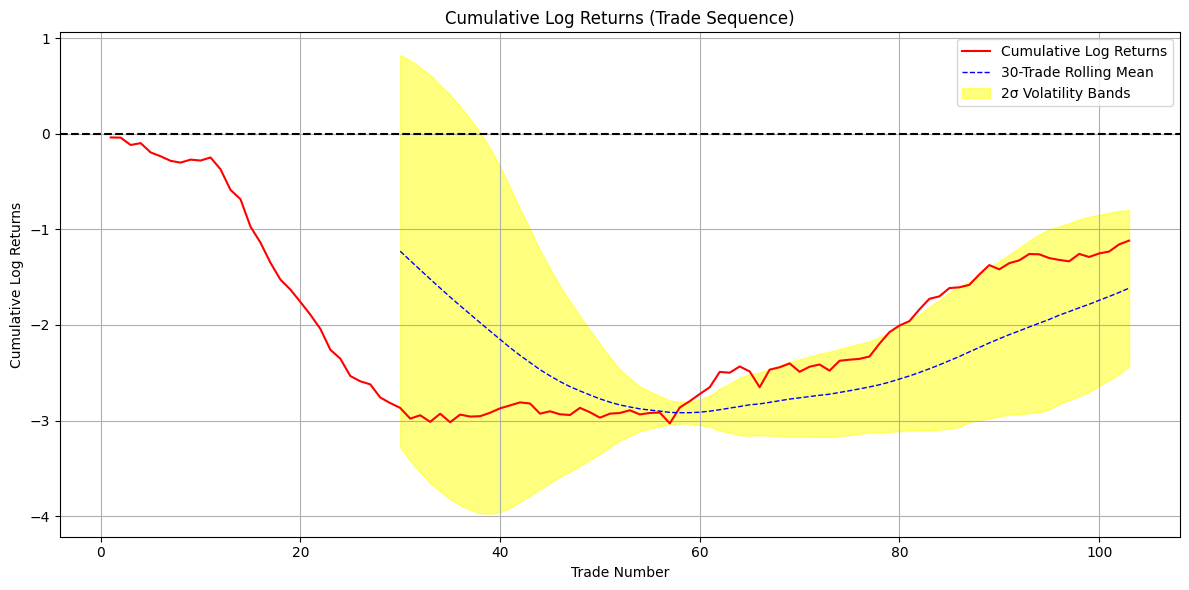

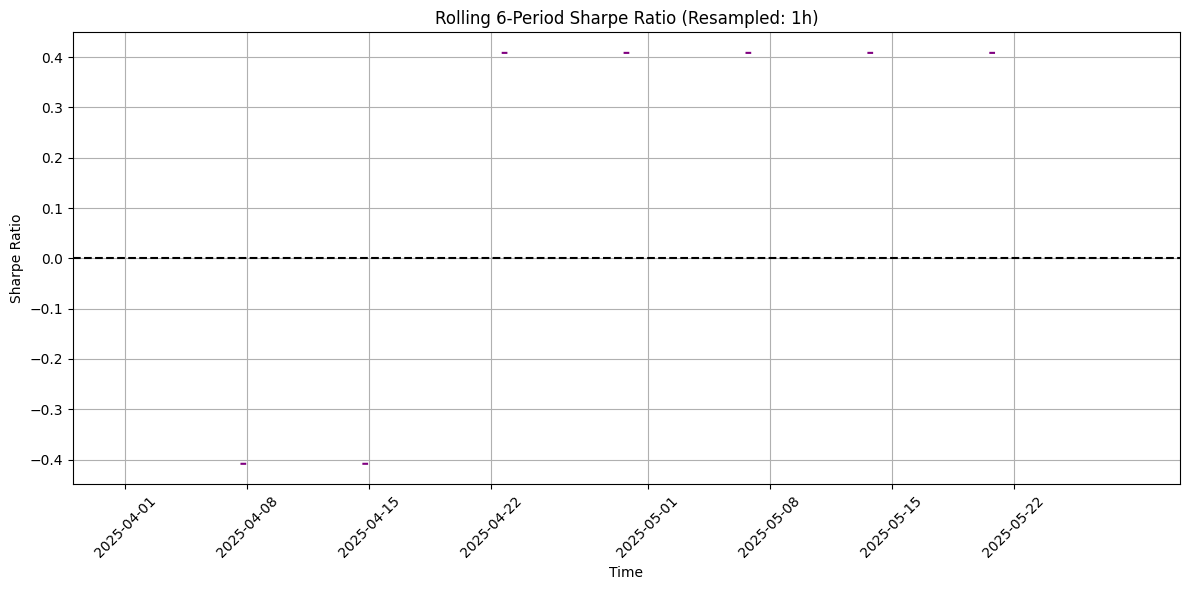

Could not generate drawdown plot: attempt to get argmax of an empty sequence


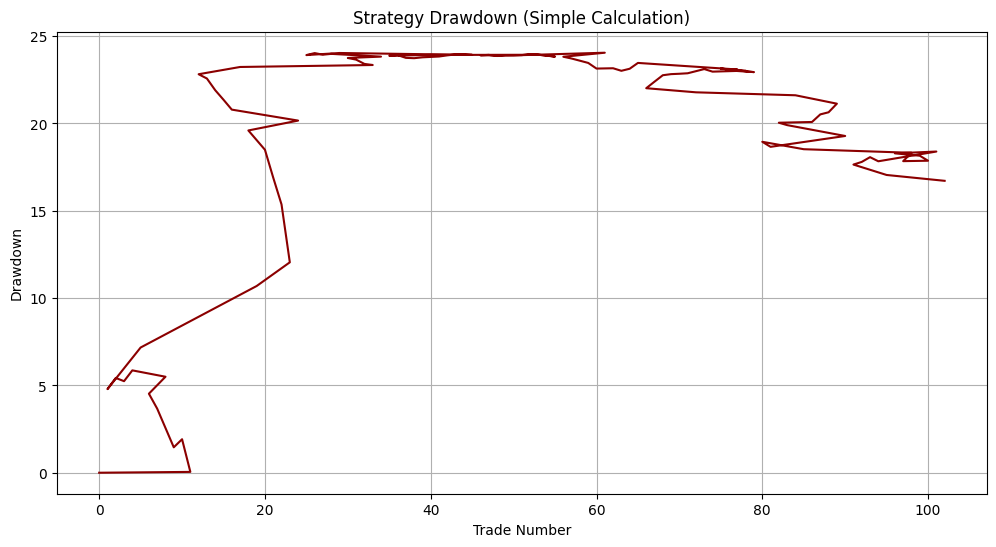


--- Return Statistics ---
count    103.0000
mean      -0.0068
std        0.0879
min       -0.2496
10%       -0.1242
25%       -0.0559
50%        0.0039
75%        0.0451
90%        0.0900
99%        0.1811
99.9%      0.2002
99.99%     0.2022
max        0.2024

--- Worst Outcomes (Bottom 1.0%) ---
Worst 1.0000%: -0.1957
Worst 0.1000%: -0.2441
Worst 0.0100%: -0.2491


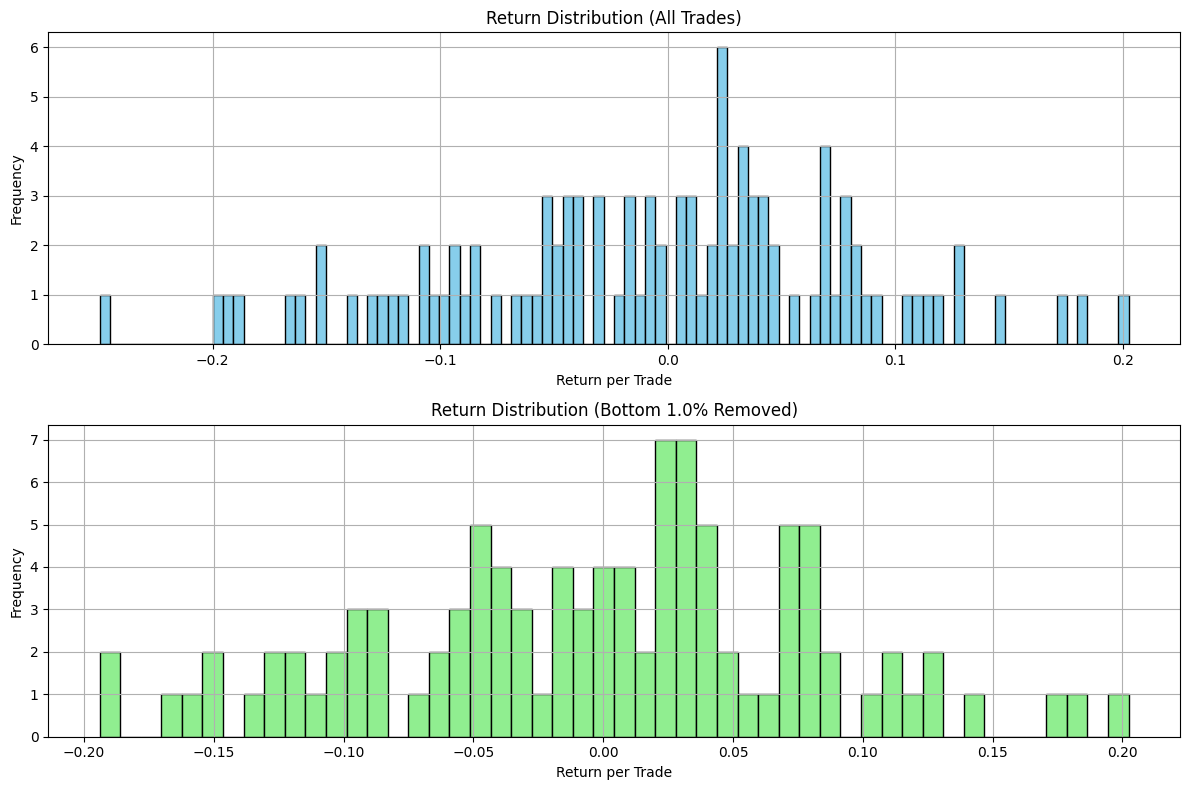

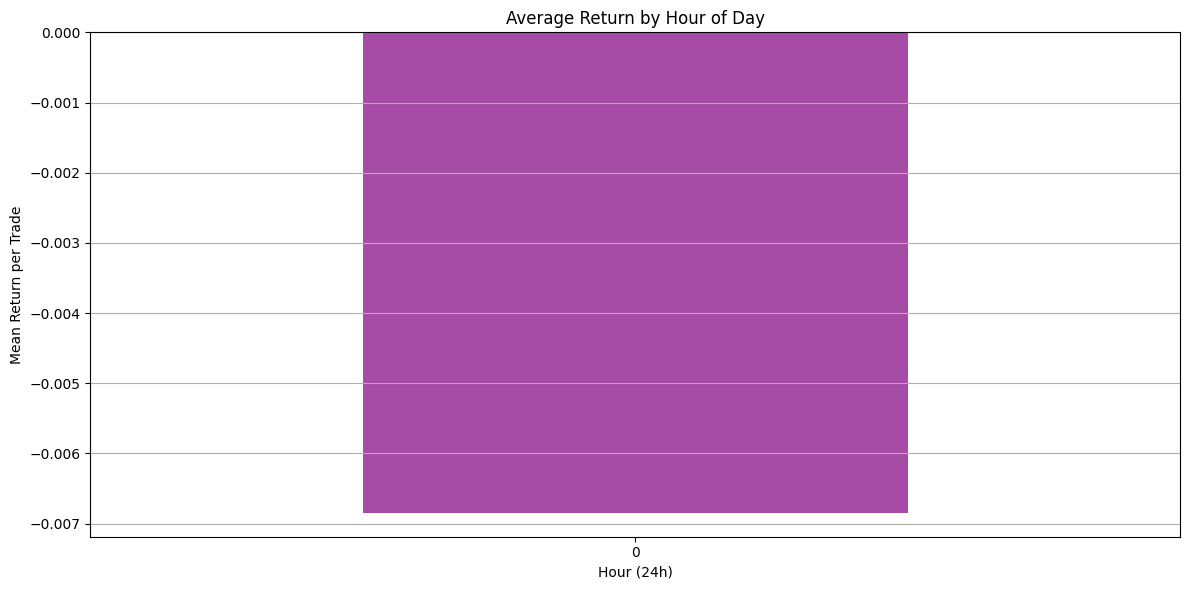


--- 1 Day Kelly Simulations ---

Kelly Fraction: 100%
count   5000.00
mean    1280.20
std      176.81
min      777.05
1%       916.93
10%     1061.06
25%     1154.23
50%     1270.84
75%     1394.21
90%     1513.76
99%     1729.73
max     2022.46


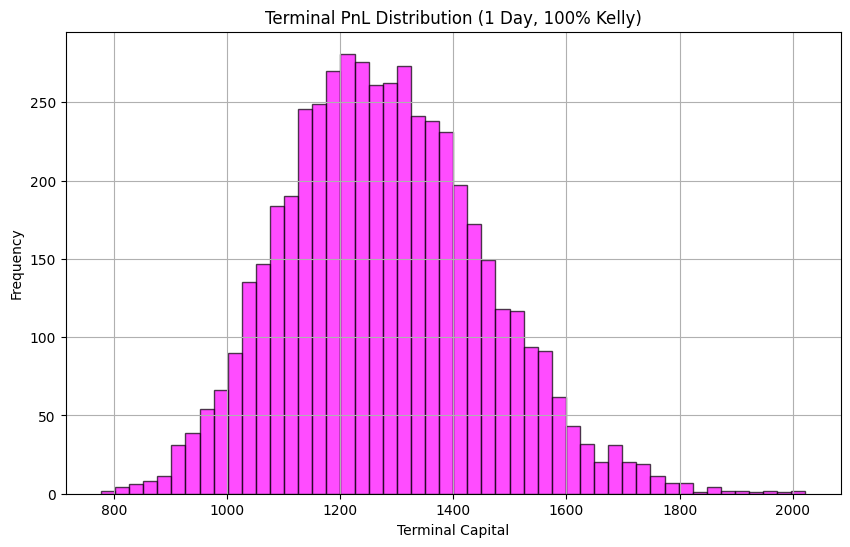

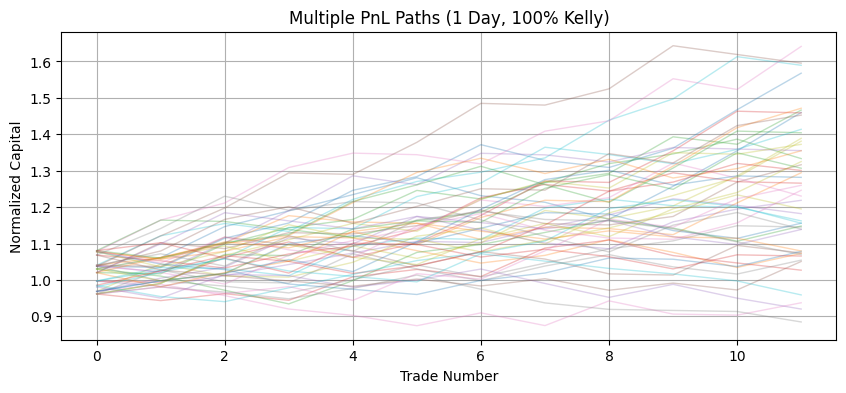


Kelly Fraction: 50%
count   5000.00
mean    1132.15
std       78.89
min      882.66
1%       959.11
10%     1032.11
25%     1077.02
50%     1130.50
75%     1184.72
90%     1235.04
99%     1321.72
max     1431.29


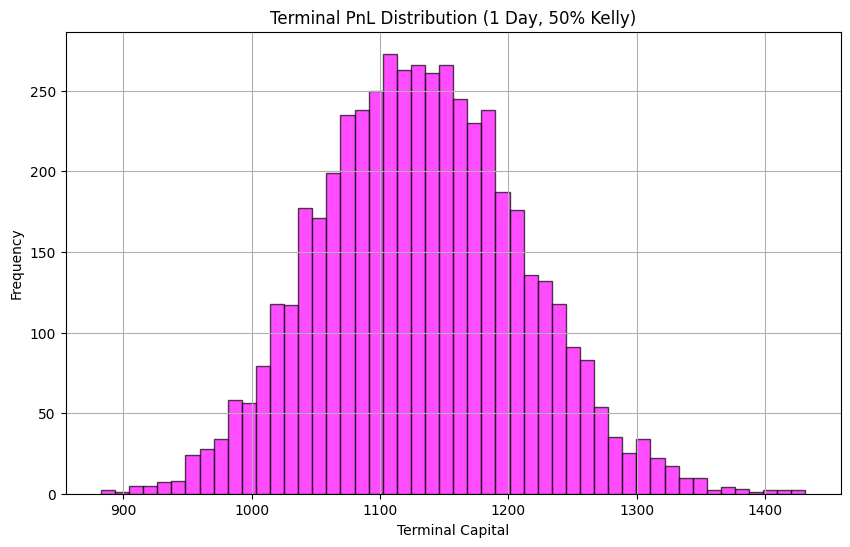

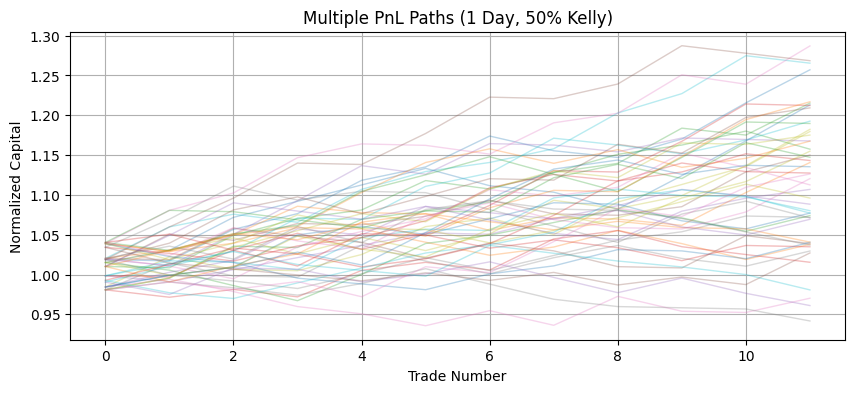


Kelly Fraction: 30%
count   5000.00
mean    1077.47
std       45.24
min      928.14
1%       975.78
10%     1019.68
25%     1046.03
50%     1077.14
75%     1107.99
90%     1136.13
99%     1183.58
max     1242.02


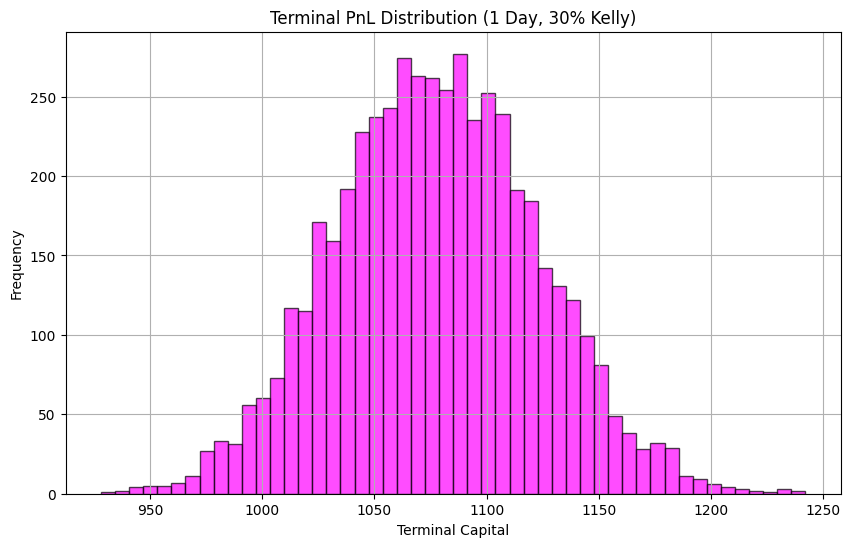

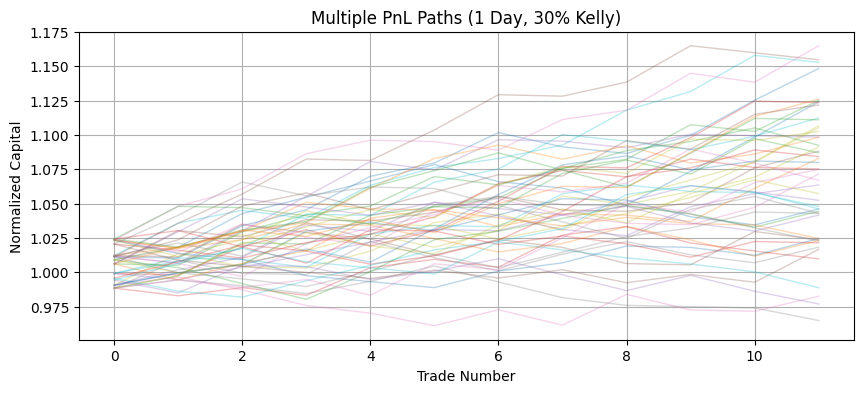


--- 3 Days Kelly Simulations ---

Kelly Fraction: 100%
count   5000.00
mean    1280.20
std      176.81
min      777.05
1%       916.93
10%     1061.06
25%     1154.23
50%     1270.84
75%     1394.21
90%     1513.76
99%     1729.73
max     2022.46


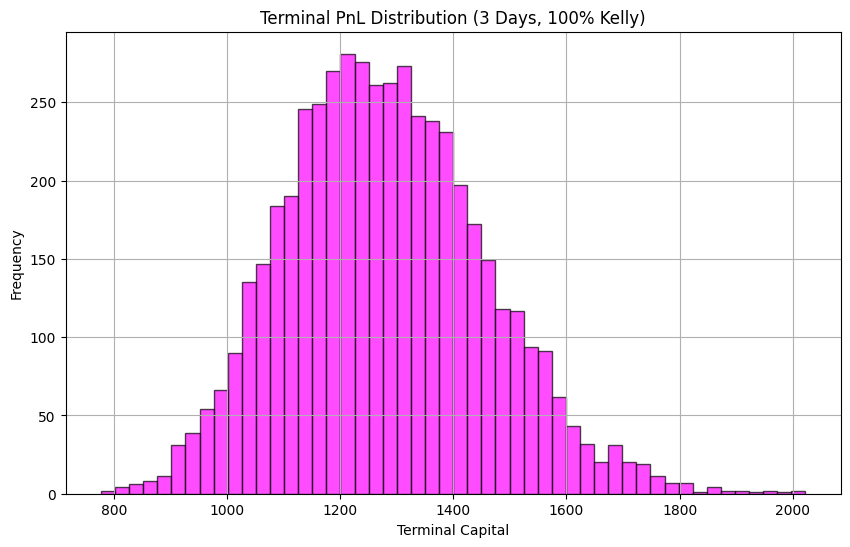

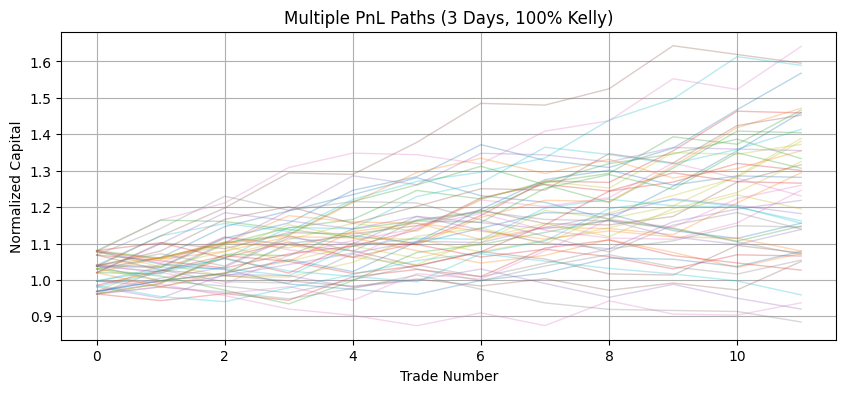


Kelly Fraction: 50%
count   5000.00
mean    1132.15
std       78.89
min      882.66
1%       959.11
10%     1032.11
25%     1077.02
50%     1130.50
75%     1184.72
90%     1235.04
99%     1321.72
max     1431.29


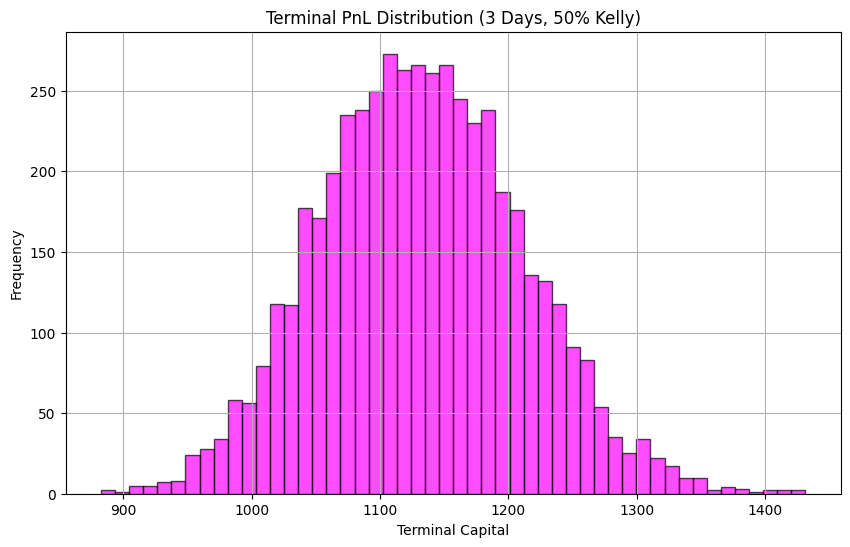

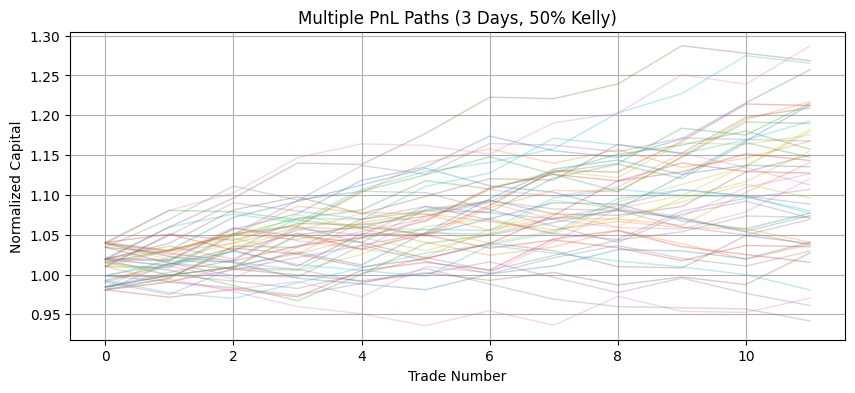


Kelly Fraction: 30%
count   5000.00
mean    1077.47
std       45.24
min      928.14
1%       975.78
10%     1019.68
25%     1046.03
50%     1077.14
75%     1107.99
90%     1136.13
99%     1183.58
max     1242.02


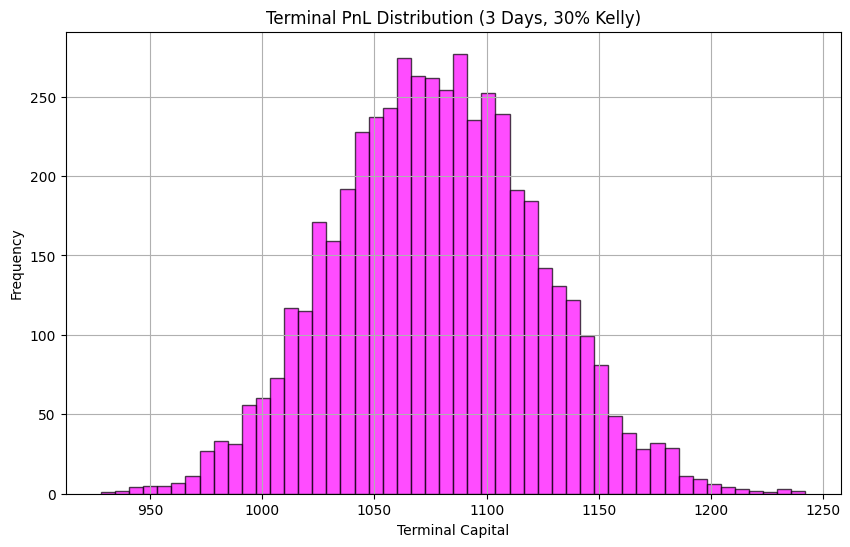

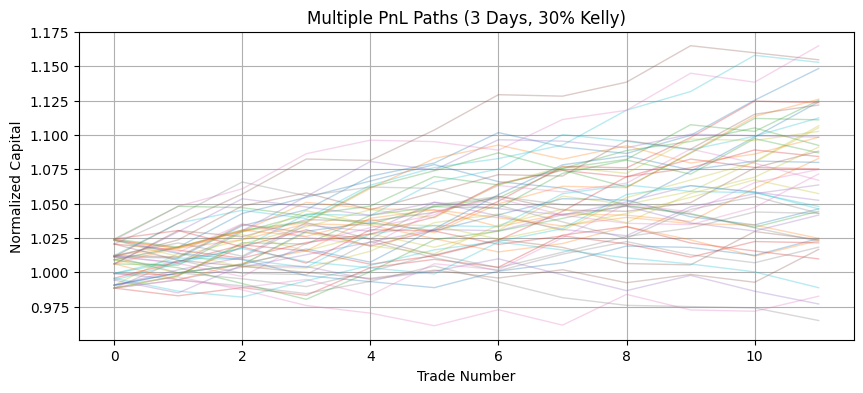


--- 1 Week Kelly Simulations ---

Kelly Fraction: 100%
count   5000.00
mean    1280.20
std      176.81
min      777.05
1%       916.93
10%     1061.06
25%     1154.23
50%     1270.84
75%     1394.21
90%     1513.76
99%     1729.73
max     2022.46


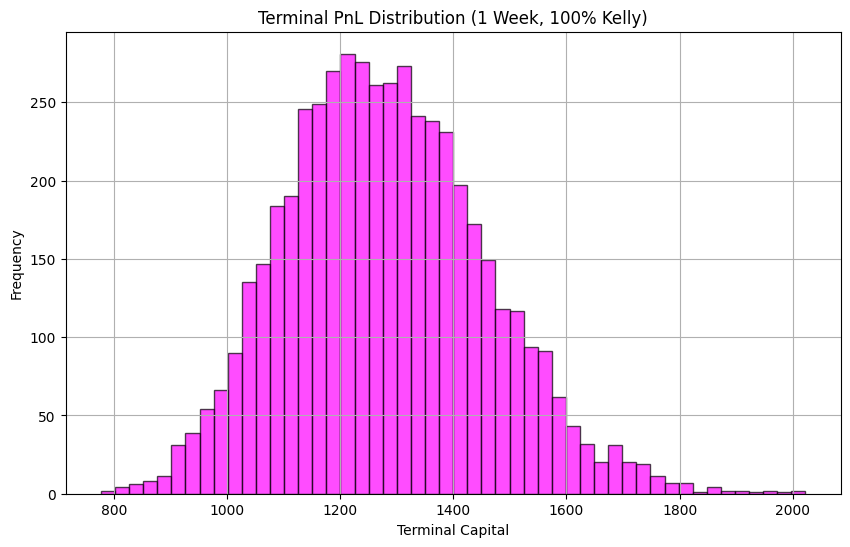

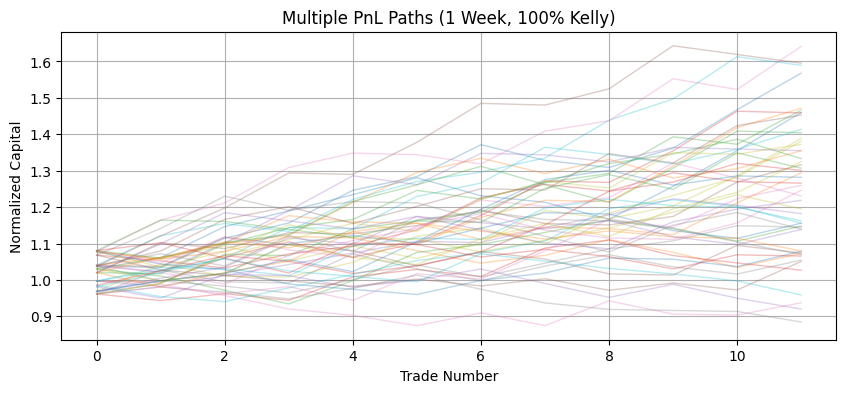


Kelly Fraction: 50%
count   5000.00
mean    1132.15
std       78.89
min      882.66
1%       959.11
10%     1032.11
25%     1077.02
50%     1130.50
75%     1184.72
90%     1235.04
99%     1321.72
max     1431.29


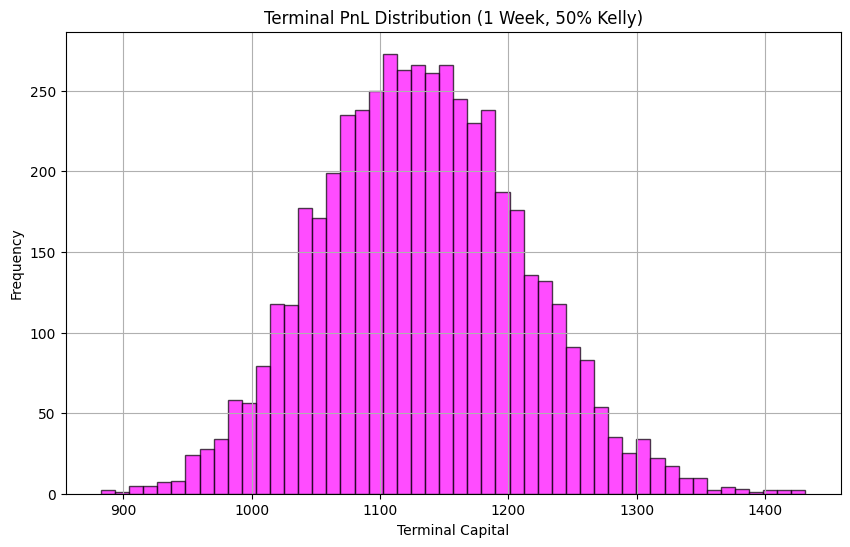

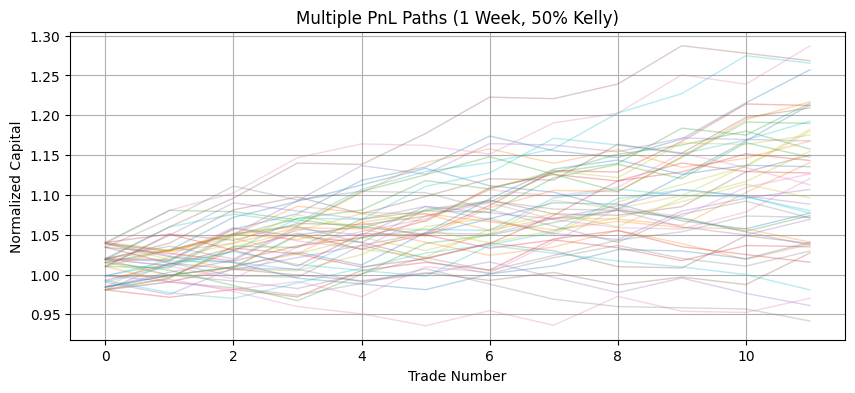


Kelly Fraction: 30%
count   5000.00
mean    1077.47
std       45.24
min      928.14
1%       975.78
10%     1019.68
25%     1046.03
50%     1077.14
75%     1107.99
90%     1136.13
99%     1183.58
max     1242.02


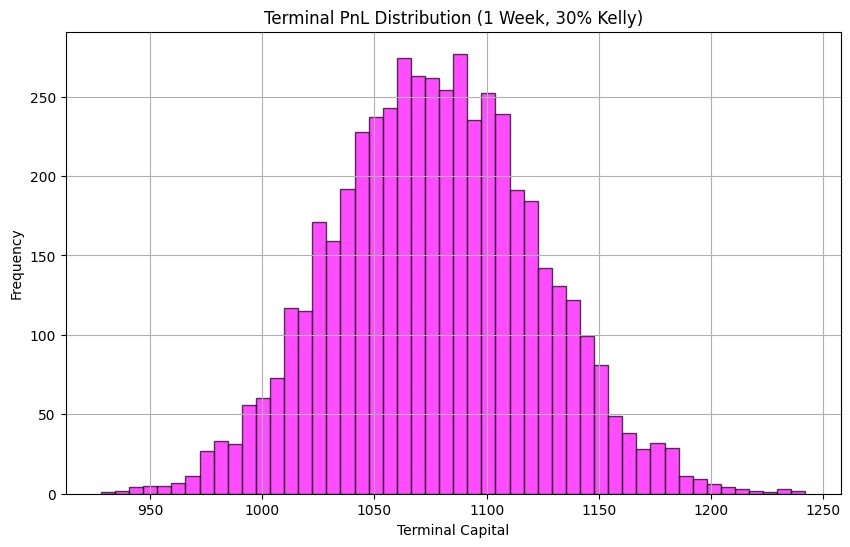

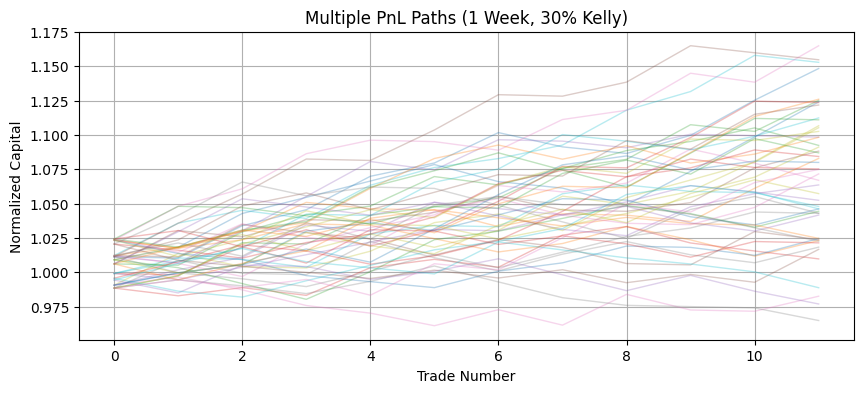


--- Full Dataset Kelly Simulations ---

Kelly Fraction: 100%
count   5000.00
mean     495.66
std      538.63
min       13.08
1%        41.91
10%      101.80
25%      177.41
50%      328.57
75%      611.76
90%     1056.97
99%     2765.35
max     6349.48


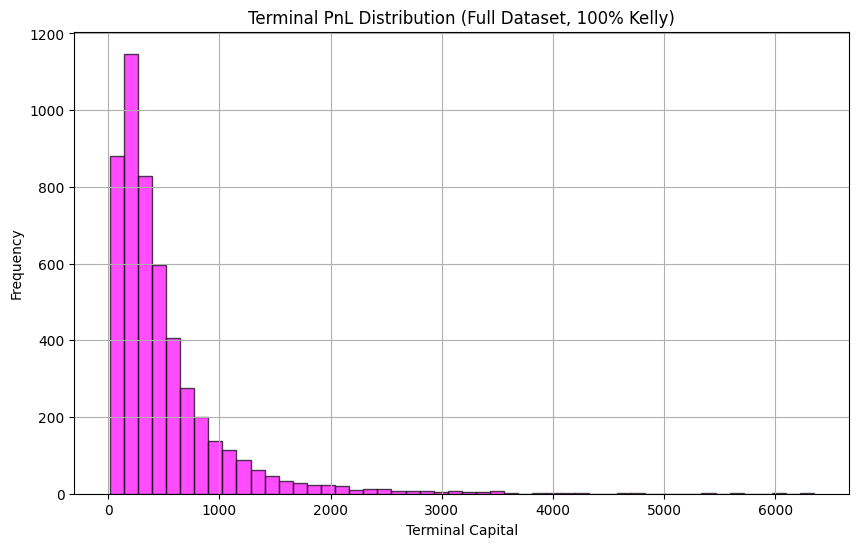

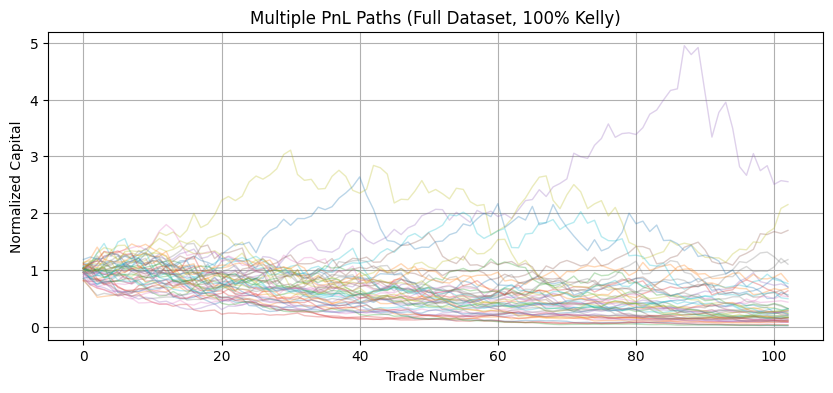


Kelly Fraction: 50%
count   5000.00
mean     704.78
std      330.09
min      131.39
1%       233.37
10%      357.53
25%      469.16
50%      637.54
75%      864.99
90%     1134.46
99%     1810.88
max     2762.88


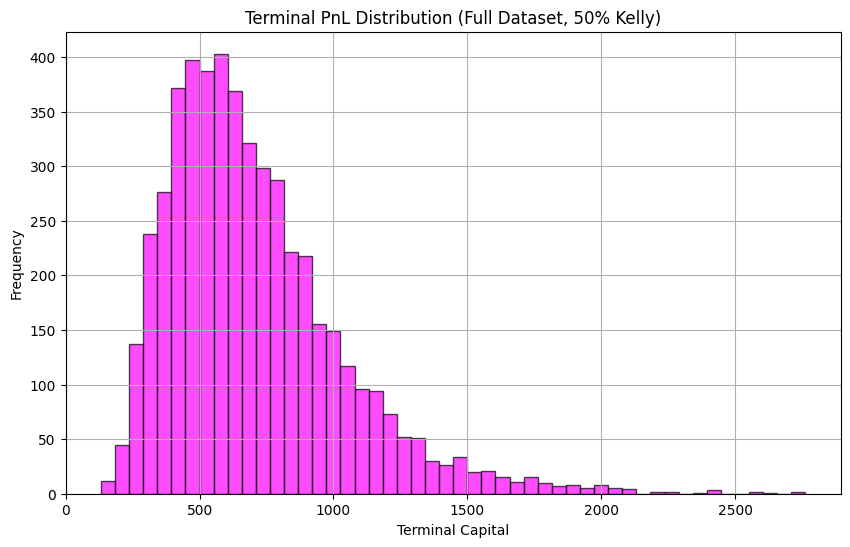

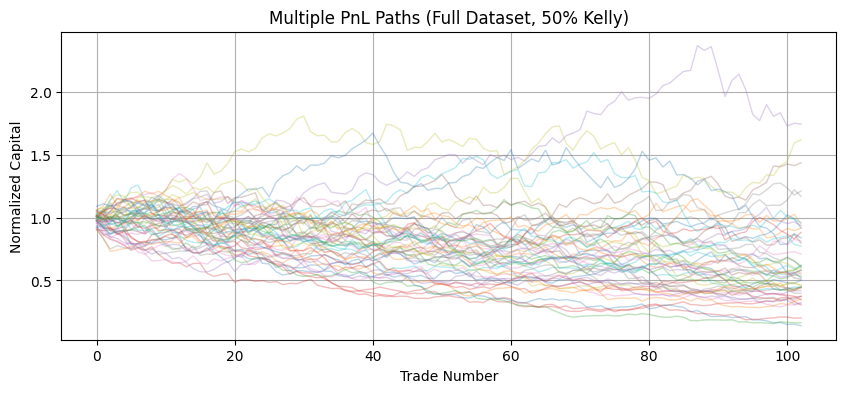


Kelly Fraction: 30%
count   5000.00
mean     810.81
std      220.29
min      305.31
1%       430.16
10%      553.54
25%      650.88
50%      782.03
75%      938.51
90%     1103.42
99%     1452.64
max     1883.65


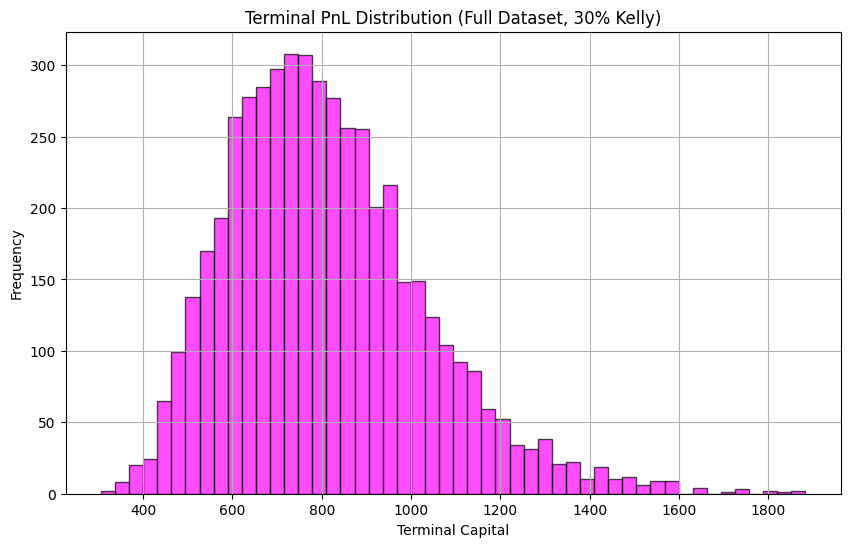

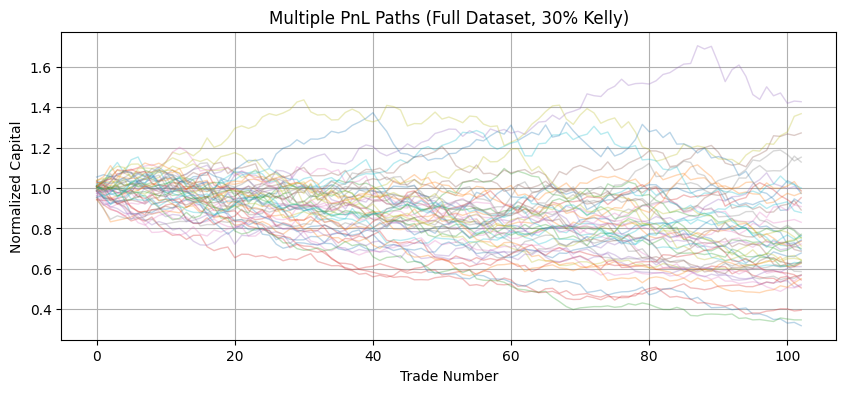

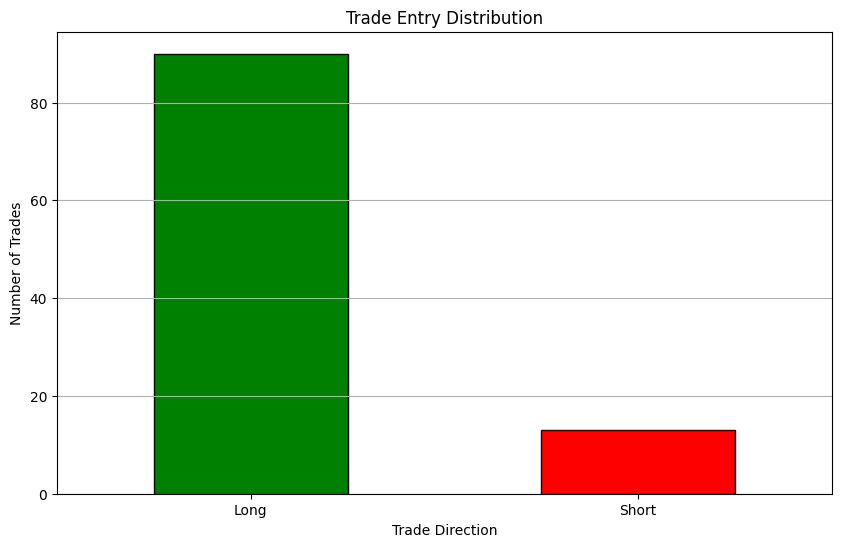

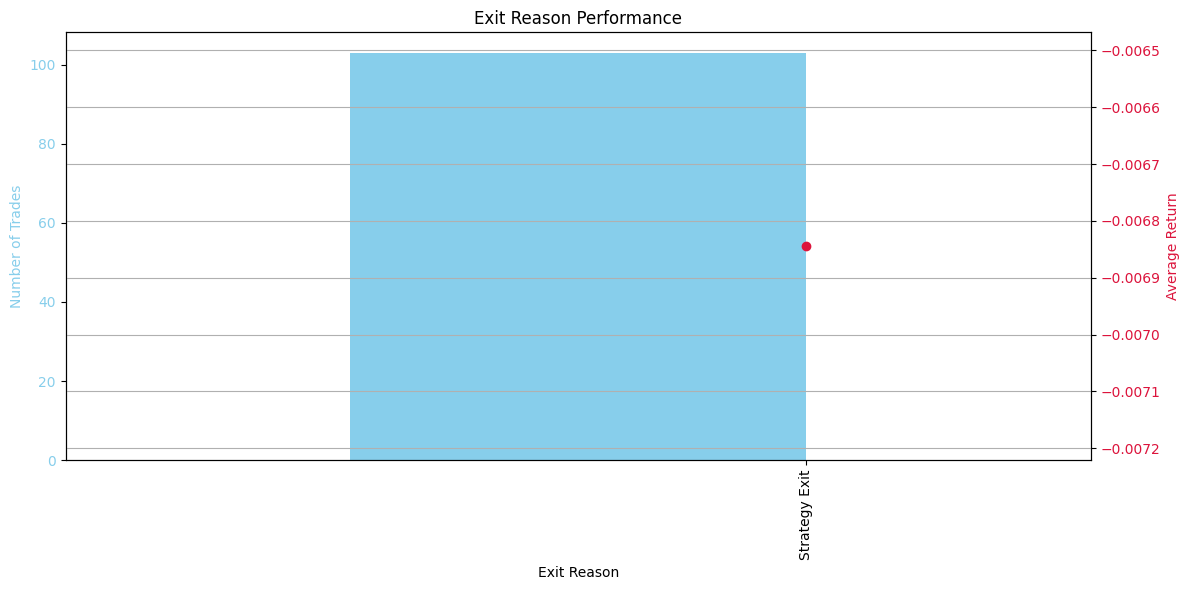


--- Trade Direction Summary ---
Direction
Long     90
Short    13

--- Exit Reason Performance ---
              Count Avg Return
Exit Reason                   
Strategy Exit   103    -0.0068


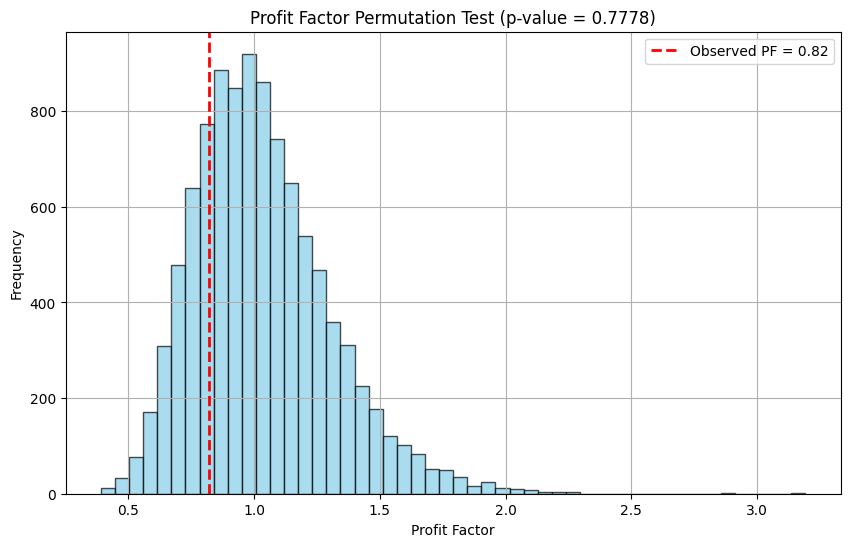


=== Profit Factor Permutation Test ===
Observed Profit Factor: 0.8201
Mean Permutation Profit Factor: 1.0312
P-value: 0.7778
Result: The observed profit factor is NOT statistically significant (p >= 0.05)

Profit Factor Permutation Test p-value: 0.7778
Result: Profit factor not statistically significant (p >= 0.05)

Additional Performance Analysis

--- Performance by Market Cap ---
         Count  Avg Return  Total Return   Std Dev  Win Rate  Profit Factor
CapSize                                                                    
Large       48   -0.007245     -0.347747  0.081097  0.437500       0.801635
Mega        51    0.000453      0.023120  0.090465  0.607843       1.012974
Mid          4   -0.095095     -0.380380  0.109186  0.250000       0.010149

--- Performance by Sector ---
                        Count  Avg Return  Total Return   Std Dev  Win Rate
Sector                                                                     
Communication Services     21    0.008080      0.16

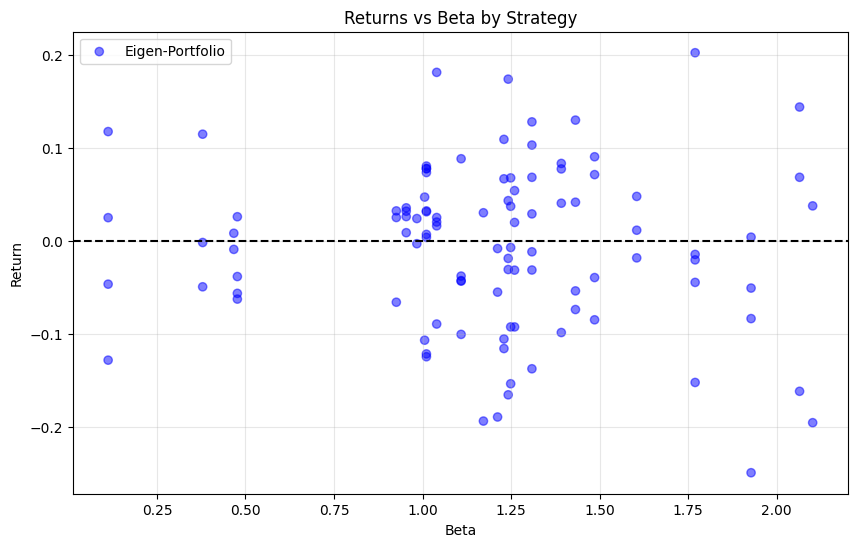


Symbol Analysis

--- Performance by Symbol ---
        Count  Avg Return  Total Return   Std Dev  Win Rate  Profit Factor
Symbol                                                                    
AAPL        5   -0.027357     -0.136787  0.069589  0.200000       0.392244
ADBE        4    0.009249      0.036997  0.085063  0.500000       1.296824
AMGN        4   -0.032989     -0.131955  0.040578  0.250000       0.163995
AMZN        7    0.021022      0.147153  0.090836  0.571429       1.812624
ASML        5   -0.029804     -0.149019  0.091980  0.400000       0.412876
AVGO        2   -0.081939     -0.163878  0.158533  0.500000       0.155437
BIIB        4   -0.008184     -0.032735  0.104640  0.500000       0.813099
BKNG        4    0.025573      0.102294  0.085013  0.750000       2.035988
CMCSA       3   -0.002974     -0.008921  0.054814  0.666667       0.865106
COST        4    0.025509      0.102037  0.011855  1.000000            inf
GILD        3    0.021110      0.063330  0.084509  0

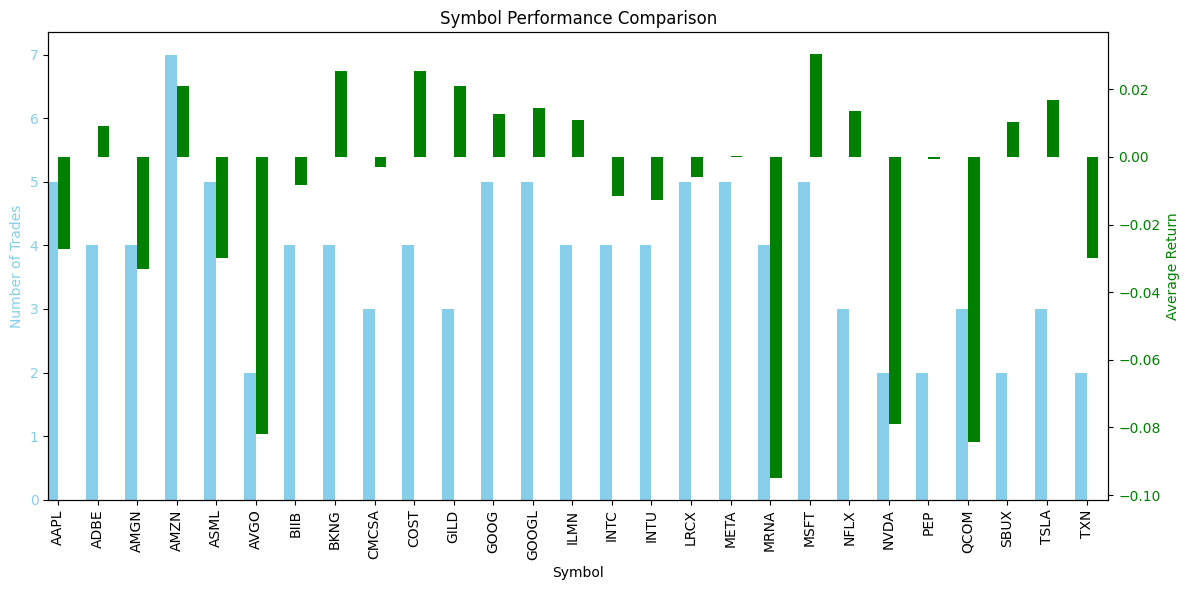

In [11]:
if not results.empty:
    # Collect metrics for all tickers
    all_metrics = []
    for ticker in set(results['Symbol']):
        metrics = get_stock_metrics(ticker)
        all_metrics.append(metrics)

    # Create metrics dataframe
    metrics_df = pd.DataFrame(all_metrics)

    # Merge with aggregated results
    symbol_perf = pd.merge(
        results, 
        metrics_df,
        on='Symbol'
    )

    # Ensure required columns for graphs.py functions exist
    results = results.copy()
    if 'Exit Time' not in results.columns and 'Exit Date' in results.columns:
        results['Exit Time'] = pd.to_datetime(results['Exit Date']) + pd.Timedelta(hours=16)  # Market close
    if 'DateTime' not in results.columns and 'Entry Date' in results.columns:
        results['DateTime'] = pd.to_datetime(results['Entry Date'])
    
    # Add missing Exit Reason column if needed
    if 'Exit Reason' not in results.columns:
        results['Exit Reason'] = 'Strategy Exit'  # Default value
    
    # Generate individual plots instead of full report to handle errors
    try:
        plot_cumulative_returns(results, rolling_window=30)
    except Exception as e:
        print(f"Could not generate cumulative returns plot: {e}")
    
    try:
        plot_rolling_sharpe_ratio(results, window_hours=6, resample_freq='1h')
    except Exception as e:
        print(f"Could not generate rolling Sharpe ratio plot: {e}")
    
    try:
        plot_drawdown(results)
    except Exception as e:
        print(f"Could not generate drawdown plot: {e}")
        # Create a simple drawdown plot as fallback
        plt.figure(figsize=(12, 6))
        cumulative_returns = (1 + results['Return']).cumprod() - 1
        peak = cumulative_returns.expanding(min_periods=1).max()
        drawdown = (cumulative_returns - peak) / peak
        plt.plot(drawdown, color='darkred', linewidth=1.5)
        plt.title('Strategy Drawdown (Simple Calculation)')
        plt.xlabel('Trade Number')
        plt.ylabel('Drawdown')
        plt.grid(True)
        plt.show()
    
    try:
        plot_return_distribution(results, zoom_percentile=0.01)
    except Exception as e:
        print(f"Could not generate return distribution plot: {e}")
    
    try:
        plot_returns_by_hour(results)
    except Exception as e:
        print(f"Could not generate returns by hour plot: {e}")
    
    try:
        plot_kelly_criterion_analysis(results)
    except Exception as e:
        print(f"Could not generate Kelly criterion analysis: {e}")
    
    try:
        plot_trade_direction_and_exit_analysis(results)
    except Exception as e:
        print(f"Could not generate trade direction analysis: {e}")
        # Simple trade direction plot as fallback
        if 'Direction' in results.columns:
            plt.figure(figsize=(10, 6))
            direction_counts = results['Direction'].value_counts()
            colors = ['green' if dir == 'Long' else 'red' for dir in direction_counts.index]
            direction_counts.plot(kind='bar', color=colors, edgecolor='black')
            plt.title('Trade Direction Distribution')
            plt.xlabel('Trade Direction')
            plt.ylabel('Number of Trades')
            plt.xticks(rotation=0)
            plt.grid(axis='y')
            plt.show()
    
    # Run permutation test with error handling
    returns_array = results['Return'].values
    
    try:
        p_value = perform_profit_factor_permutation_test(returns_array, n_permutations=10000)
        
        # Display p-value
        print(f"\nProfit Factor Permutation Test p-value: {p_value:.4f}")
        if p_value < 0.05:
            print("Result: Statistically significant profit factor (p < 0.05)")
        else:
            print("Result: Profit factor not statistically significant (p >= 0.05)")
            
    except Exception as e:
        print(f"Could not perform profit factor permutation test: {e}")
        
        # Calculate basic profit factor as fallback
        try:
            pf = calculate_profit_factor(returns_array)
            print(f"\nProfit Factor: {pf:.4f}")
            
            # Check if there are any losses
            if np.any(returns_array < 0):
                print("Note: Profit factor calculation is valid (both gains and losses present)")
            else:
                print("Warning: No losses in returns - profit factor may be infinite")
                
        except Exception as pf_error:
            print(f"Could not calculate profit factor: {pf_error}")

    # -------------------------------
    # Additional Performance Analysis (Not covered by graphs.py)
    # -------------------------------
    print("\n" + "="*40 + "\nAdditional Performance Analysis\n" + "="*40)

    # Performance by Market Cap
    cap_size_perf = symbol_perf.groupby('CapSize').agg({
        'Return': ['count', 'mean', 'sum', 'std'],
    })
    cap_size_perf.columns = ['Count', 'Avg Return', 'Total Return', 'Std Dev']
    cap_size_perf['Win Rate'] = symbol_perf.groupby('CapSize')['Return'].apply(
        lambda x: (x > 0).mean()
    )
    cap_size_perf['Profit Factor'] = symbol_perf.groupby('CapSize')['Return'].apply(
        lambda x: calculate_profit_factor(x.values) if np.any(x < 0) else float('inf')
    )   
    print("\n--- Performance by Market Cap ---")
    print(cap_size_perf)

    # Performance by Sector
    sector_perf = symbol_perf.groupby('Sector').agg({
        'Return': ['count', 'mean', 'sum', 'std'],
    })
    sector_perf.columns = ['Count', 'Avg Return', 'Total Return', 'Std Dev']
    sector_perf['Win Rate'] = symbol_perf.groupby('Sector')['Return'].apply(
        lambda x: (x > 0).mean()
    )
    print("\n--- Performance by Sector ---")
    print(sector_perf)

    # Strategy by Market Cap
    strategy_cap = symbol_perf.groupby(['Strategy', 'CapSize']).agg({
        'Return': ['count', 'mean', 'sum']
    })
    strategy_cap.columns = ['Count', 'Avg Return', 'Total Return']
    print("\n--- Strategy by Market Cap ---")
    print(strategy_cap)

    # Returns vs Beta scatter plot
    if 'Beta' in symbol_perf.columns:
        plt.figure(figsize=(10, 6))
        plt.scatter(
            symbol_perf['Beta'], 
            symbol_perf['Return'],
            alpha=0.5, 
            c=symbol_perf['Strategy'].map({'Eigen-Portfolio': 'blue'})
        )
        plt.axhline(y=0, color='black', linestyle='--')
        plt.xlabel('Beta')
        plt.ylabel('Return')
        plt.title('Returns vs Beta by Strategy')
        plt.legend(['Eigen-Portfolio'])
        plt.grid(True, alpha=0.3)
        plt.show()
    else:
        print("Beta data not available for scatter plot")

    # Symbol Analysis
    if 'Symbol' in results.columns:
        print("\n" + "="*40 + "\nSymbol Analysis\n" + "="*40)
        
        symbol_perf = results.groupby('Symbol').agg({
            'Return': ['count', 'mean', 'sum', 'std'],
        })
        
        symbol_perf.columns = ['Count', 'Avg Return', 'Total Return', 'Std Dev']
        symbol_perf['Win Rate'] = results.groupby('Symbol')['Return'].apply(
            lambda x: (x > 0).mean()
        )
        symbol_perf['Profit Factor'] = results.groupby('Symbol')['Return'].apply(
            lambda x: calculate_profit_factor(x.values) if np.any(x < 0) else float('inf')
        )
        
        print("\n--- Performance by Symbol ---")
        print(symbol_perf)
        
        plt.figure(figsize=(12, 6))
        ax = plt.gca()
        
        # Bar chart for count
        symbol_perf['Count'].plot(kind='bar', color='skyblue', ax=ax, position=1, width=0.3)
        ax.set_ylabel('Number of Trades', color='skyblue')
        ax.tick_params(axis='y', labelcolor='skyblue')
        
        # Secondary axis for return
        ax2 = ax.twinx()
        symbol_perf['Avg Return'].plot(kind='bar', color='green', ax=ax2, position=0, width=0.3)
        ax2.set_ylabel('Average Return', color='green')
        ax2.tick_params(axis='y', labelcolor='green')
        
        plt.title('Symbol Performance Comparison')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
else:
    print("No trades found with the given strategy.")